In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table

In [2]:
# Training settings
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.1
MOMENTUM = 0.9
NO_CUDA = False
SEED = 1
CLASSES = 10
MODEL_PATH_ROOT = './weights/wrn-28-10-cifar10'
MODEL_PATH = MODEL_PATH_ROOT + '.pth'

# MNIST mean and stdevs of training data by channel
CHANNEL_MEANS = (125.30691727995872/255, 122.95035973191261/255, 113.86546522378922/255)
CHANNEL_STDS = (62.993244007229805/255, 62.08868734538555/255, 66.70485824346542/255)

# Plot ROC and PR curves
PLOT_CHARTS = False

## Training and Testing functions

In [3]:
from novelty.utils import Progbar


def train(model, device, train_loader, optimizer, epoch):
    progbar = Progbar(target=len(train_loader.dataset))

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        progbar.add(len(data), [("loss", loss.item())])  

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    
    return test_loss, test_acc

## Initialize model and load MNIST

In [5]:
from novelty.utils import DATA_DIR
from src.wide_resnet import Wide_ResNet

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join(DATA_DIR, 'cifar10'), train=True, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join(DATA_DIR, 'cifar10'), train=False, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

# Create model instance
model = Wide_ResNet(28, 10, 0.0, CLASSES)
model = model.to(device)

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(EPOCHS*0.5), int(EPOCHS*0.75)], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Files already downloaded and verified
Files already downloaded and verified
| Wide-Resnet 28x10


## Optimization loop

In [6]:
if os.path.exists(MODEL_PATH):
    # load previously trained model:
    model.load_state_dict(torch.load(MODEL_PATH))

else:
    best_loss = float("inf")
    
    # Training loop
    for epoch in range(EPOCHS):
        print("Epoch:", epoch)
        scheduler.step()
        
        # Print the learning rate
        for param_group in optimizer.param_groups:
            print('Learning rate:', param_group['lr'])
        
        train(model, device, train_loader, optimizer, epoch)
        loss, acc = test(model, device, test_loader)
        
        # Checkpoint the model parameters
        if loss < best_loss:
            torch.save(model.state_dict(), "{}_epoch{}.pth".format(MODEL_PATH_ROOT, epoch))
            best_loss = loss
            

    # save the model 
    torch.save(model.state_dict(), MODEL_PATH)

## ODIN prediction functions

In [7]:
from torch.autograd import Variable


def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_temp(model, data, device, temp=1000.):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs /= temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_novelty(model, data, device, temp=1000., noiseMagnitude=0.0012):
    model.eval()

    # Create a variable so we can get the gradients on the input
    inputs = Variable(data.to(device), requires_grad=True)

    # Get the predicted labels
    outputs = model(inputs)
    outputs = outputs / temp
    outputs = F.log_softmax(outputs, dim=1)

    # Calculate the perturbation to add to the input
    maxIndexTemp = torch.argmax(outputs, dim=1)
    labels = Variable(maxIndexTemp).to(device)
    loss = F.nll_loss(outputs, labels)
    loss.backward()

    # Normalizing the gradient to binary in {0, 1}
    gradient = torch.ge(inputs.grad.data, 0)
    gradient = (gradient.float() - 0.5) * 2

    # Normalize the gradient to the same space of image
    for channel, (mean, std) in enumerate(zip(CHANNEL_MEANS, CHANNEL_STDS)):
        gradient[0][channel] = (gradient[0][channel] - mean) / std

    # Add small perturbations to image
    # TODO, this is from the released code, but disagrees with paper I think
    tempInputs = torch.add(inputs.data, -noiseMagnitude, gradient)

    # Get new outputs after perturbations
    outputs = model(Variable(tempInputs))
    outputs = outputs / temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    outputs = F.softmax(outputs, dim=1)

    return outputs

## Evaluate method on outlier datasets

In [8]:
def get_max_model_outputs(data_loader, device):
    """Get the max softmax output from the model in a Python array.

    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.

    device: object
        The CUDA device handle.
    """
    result = []
    
    for data, target in data_loader:
        # Using regular model
        p = predict(model, data, device)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result


def get_max_odin_outputs(data_loader, device, temp=1000., noiseMagnitude=0.0012):
    """Convenience function to get the max softmax values from the ODIN model in a Python array.
    
    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.
        
    device: object
        The CUDA device handle.
        
    temp: float, optional (default=1000.)
        The temp the model should use to do temperature scaling on the softmax outputs.
        
    noiseMagnitude: float, optional (default=0.0012)
        The epsilon value used to scale the input images according to the ODIN paper.
    """
    result = []
    
    for data, target in data_loader:
        # Using ODIN model
        p = predict_novelty(model, data, device, temp=temp, noiseMagnitude=noiseMagnitude)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result

In [9]:
import pandas as pd

df = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'],
                  index=['imagenet_crop', 'imagenet_resize', 'lsun_crop', 'lsun_resize', 
                         'isun_resize', 'gaussian', 'uniform'])

df_odin = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'],
                  index=['imagenet_crop', 'imagenet_resize', 'lsun_crop', 'lsun_resize', 
                         'isun_resize', 'gaussian', 'uniform'])

### Process Inliers

In [10]:
num_inliers = len(test_loader.dataset)

# Get predictions on in-distribution images
cifar_model_maximums = get_max_model_outputs(test_loader, device)

### Tiny Imagenet (Crop)

In [11]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_crop = transforms.Compose([
    transforms.RandomCrop([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
imagenet_crop_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(directory, transform=transform_crop),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_imagenet_crop = len(imagenet_crop_loader.dataset.imgs)

# Get predictions on in-distribution images
imagenet_crop_model_maximums = get_max_model_outputs(imagenet_crop_loader, device)

temp = 1000
eps = 0.0005
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
imagenet_crop_odin_maximums = get_max_odin_outputs(imagenet_crop_loader, device, temp=temp, noiseMagnitude=eps)

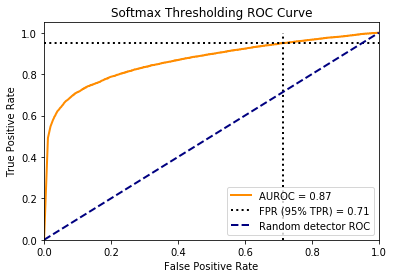

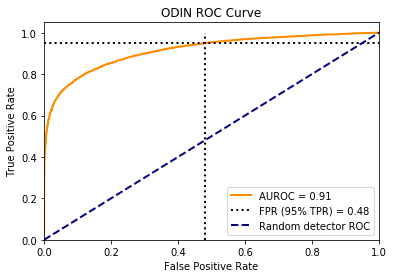

In [12]:
labels = [1] * num_inliers + [0] * num_imagenet_crop
predictions = cifar_model_maximums + imagenet_crop_model_maximums
predictions_odin = cifar_odin_maximums + imagenet_crop_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['imagenet_crop'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['imagenet_crop'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Tiny Imagenet (Resize)

In [13]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_resize = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
imagenet_resize_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(directory, transform=transform_resize),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_imagenet_resize = len(imagenet_resize_loader.dataset.imgs)

# Get predictions on in-distribution images
imagenet_resize_model_maximums = get_max_model_outputs(imagenet_resize_loader, device)

temp = 1000
eps = 0.0011
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
imagenet_resize_odin_maximums = get_max_odin_outputs(imagenet_resize_loader, device, temp=temp, noiseMagnitude=eps)

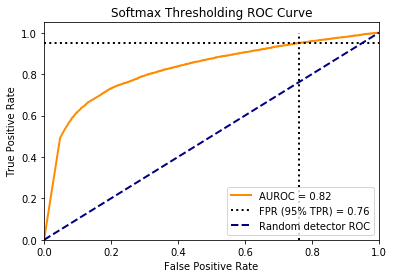

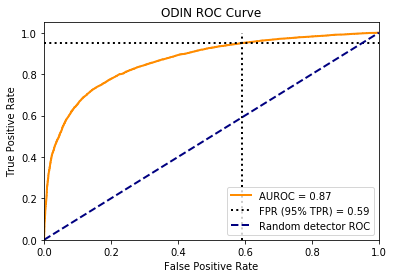

In [14]:
labels = [1] * num_inliers + [0] * num_imagenet_resize
predictions = cifar_model_maximums + imagenet_resize_model_maximums
predictions_odin = cifar_odin_maximums + imagenet_resize_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['imagenet_resize'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['imagenet_resize'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### LSUN (Crop)

In [15]:
lsun_directory = '/media/tadenoud/DATADisk/datasets/lsun'

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
lsun_crop_loader = torch.utils.data.DataLoader(
    datasets.LSUN(lsun_directory, classes='test', transform=transform_crop),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_lsun_crop = len(lsun_crop_loader.dataset)

# Get predictions on in-distribution images
lsun_crop_model_maximums = get_max_model_outputs(lsun_crop_loader, device)

temp = 1000
eps = 0.
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
lsun_crop_odin_maximums = get_max_odin_outputs(lsun_crop_loader, device, temp=temp, noiseMagnitude=eps)

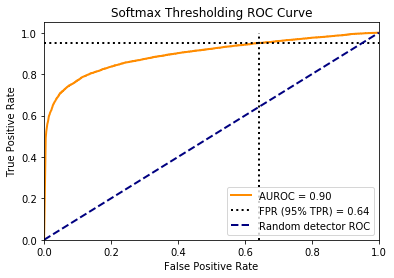

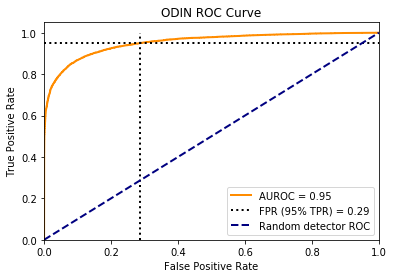

In [16]:
labels = [1] * num_inliers + [0] * num_lsun_crop
predictions = cifar_model_maximums + lsun_crop_model_maximums
predictions_odin = cifar_odin_maximums + lsun_crop_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['lsun_crop'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['lsun_crop'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### LSUN (Resize)

In [17]:
# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
lsun_resize_loader = torch.utils.data.DataLoader(
    datasets.LSUN(lsun_directory, classes='test', transform=transform_resize),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_lsun_resize = len(lsun_resize_loader.dataset)

# Get predictions on in-distribution images
lsun_resize_model_maximums = get_max_model_outputs(lsun_resize_loader, device)

temp = 1000
eps = 0.0006
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
lsun_resize_odin_maximums = get_max_odin_outputs(lsun_resize_loader, device, temp=temp, noiseMagnitude=eps)

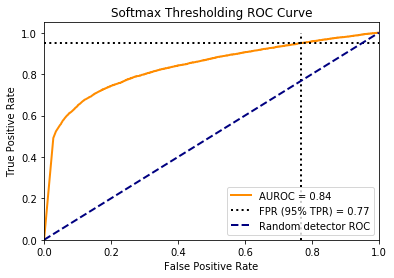

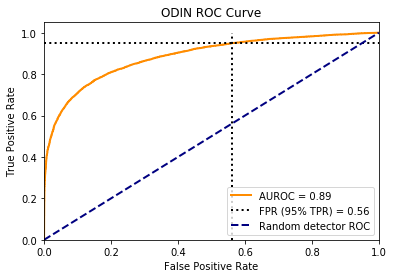

In [18]:
labels = [1] * num_inliers + [0] * num_lsun_resize
predictions = cifar_model_maximums + lsun_resize_model_maximums
predictions_odin = cifar_odin_maximums + lsun_resize_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['lsun_resize'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['lsun_resize'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### iSUN

In [19]:
isun_directory = '/media/tadenoud/DATADisk/datasets/isun'

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
isun_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(isun_directory, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_isun = len(isun_loader.dataset)

# Get predictions on in-distribution images
isun_model_maximums = get_max_model_outputs(isun_loader, device)

temp = 1000
eps = 0.0008
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
isun_odin_maximums = get_max_odin_outputs(isun_loader, device, temp=temp, noiseMagnitude=eps)

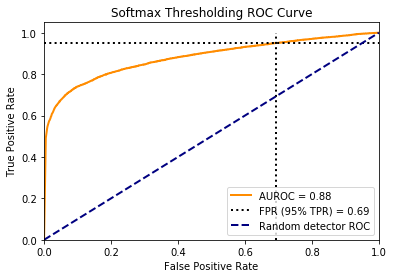

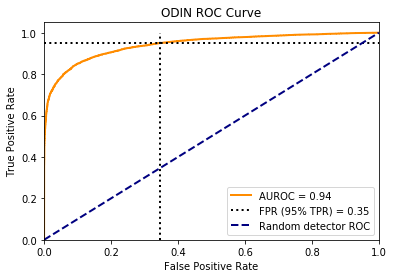

In [20]:
labels = [1] * num_inliers + [0] * num_isun
predictions = cifar_model_maximums + isun_model_maximums
predictions_odin = cifar_odin_maximums + isun_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['isun_resize'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['isun_resize'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Gaussian Noise Dataset

In [21]:
from novelty.utils.datasets import GaussianNoiseDataset

gaussian_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor()
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
gaussian_loader = torch.utils.data.DataLoader(
    GaussianNoiseDataset((10000, 32, 32, 3), mean=0., std=1., transform=gaussian_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_gaussian = len(gaussian_loader.dataset)

# Get predictions on in-distribution images
gaussian_model_maximums = get_max_model_outputs(gaussian_loader, device)

temp = 1000
eps = 0.0014
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
gaussian_odin_maximums = get_max_odin_outputs(
    gaussian_loader, device, temp=temp, noiseMagnitude=eps)

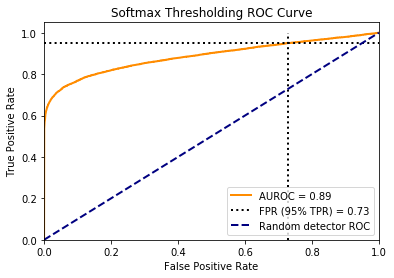

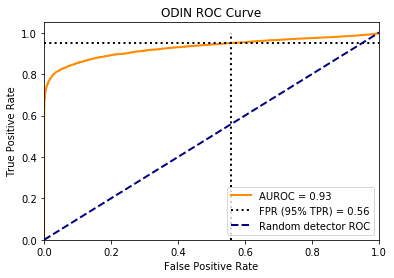

In [22]:
labels = [1] * num_inliers + [0] * num_gaussian
predictions = cifar_model_maximums + gaussian_model_maximums
predictions_odin = cifar_odin_maximums + gaussian_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['gaussian'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['gaussian'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

    barcode_plot(predictions_odin, labels)

### Uniform Noise Dataset

In [ ]:
from novelty.utils.datasets import UniformNoiseDataset
import math

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
uniform_loader = torch.utils.data.DataLoader(
    UniformNoiseDataset((10000, 32, 32, 3), low=-math.sqrt(3.), high=math.sqrt(3.), transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_uniform = len(uniform_loader.dataset)

# Get predictions on in-distribution images
uniform_model_maximums = get_max_model_outputs(uniform_loader, device)

temp = 1
eps = 0.0032
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
uniform_odin_maximums = get_max_odin_outputs(
    uniform_loader, device, temp=temp, noiseMagnitude=eps)

In [ ]:
labels = [1] * num_inliers + [0] * num_uniform
predictions = cifar_model_maximums + uniform_model_maximums
predictions_odin = cifar_odin_maximums + uniform_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['uniform'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['uniform'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

    barcode_plot(predictions_odin, labels)

# Save results

In [27]:
df.to_pickle('./results/cifar10_wrn28_10_liang2018.pkl')
df_odin.to_pickle('./results/cifar10_wrn28_10_odin_liang2018.pkl')

In [29]:
df_odin

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
imagenet_crop,0.914593,0.929949,0.892329,0.4819,0.2659
imagenet_resize,0.866392,0.87356,0.84646,0.5913,0.32065
lsun_crop,0.951828,0.95979,0.941048,0.2869,0.1684
lsun_resize,0.88642,0.902553,0.862309,0.5621,0.30605
isun_resize,0.94224,0.956856,0.918402,0.345994,0.197997
gaussian,0.929165,0.951102,0.872025,0.558,0.30395
uniform,0.928717,0.95079,0.869248,0.5543,0.3021


In [28]:
df

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
imagenet_crop,0.866414,0.89447,0.819948,0.7148,0.38235
imagenet_resize,0.824451,0.848793,0.781995,0.7601,0.405
lsun_crop,0.896567,0.919856,0.858809,0.6416,0.34575
lsun_resize,0.835986,0.865117,0.787708,0.7663,0.4081
isun_resize,0.88012,0.914898,0.820114,0.693109,0.371555
gaussian,0.885994,0.919179,0.824095,0.7299,0.3899
uniform,0.889961,0.922012,0.829742,0.7212,0.38555
